# Evaluation of GRN inference methods
## Explanatory analysis
### by Jalil Nourisa



# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
from scipy.stats import spearmanr
import gseapy as gp


# from mplfonts import use_font

sys.path.append('../../')
from grn_benchmark.src.helper import surragate_names
from task_grn_inference.src.utils.util import colors_blind
from task_grn_inference.src.exp_analysis.helper import *


controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

task_grn_inference_dir = '../../task_grn_inference'
results_folder = '../results_folder/'

plt.rcParams['font.family'] = 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

def binarize_weight(weight):
    if weight > 0:
        return 1
    elif weight < 0:
        return -1
    else:
        return 0
%matplotlib inline

['Liberation Sans']


# Perturbation effects 

In [15]:
perturbation_dict = {}
datasets = ['op','replogle2','nakatake']
for dataset in datasets: 
    perturbation_data = ad.read_h5ad(f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad')
    perturbation_dict[dataset] = perturbation_data

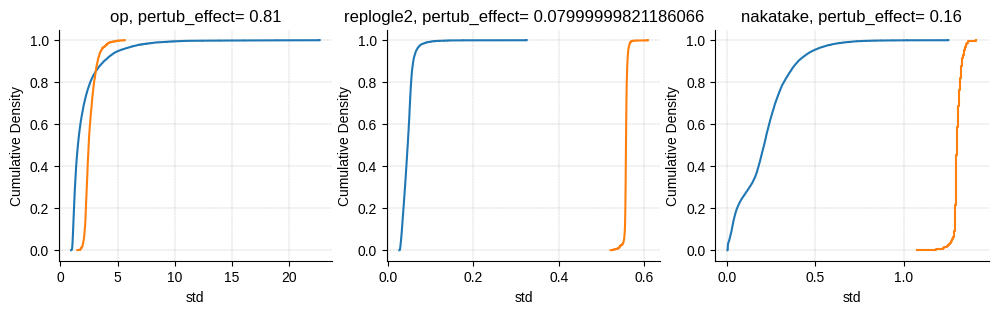

In [18]:
def plot_pertub_effect(adata, layer=None, ax=None, title=''):
    if layer is not None:
        adata.X = adata.layers[layer]
    try:
        y_true = adata.X.todense().A
    except:
        y_true = adata.X
    pertub_effect = round(np.std(y_true, axis=0).mean()/np.std(y_true, axis=1).mean(), 2)

    plot_cumulative_density(np.std(y_true, axis=0), ax=ax, label='std between samples', x_label='std')
    plot_cumulative_density(np.std(y_true, axis=1), ax=ax, label='std within samples',x_label='std')
    ax.set_title(f'{title}, pertub_effect= {pertub_effect:.2f}')

fig, axes = plt.subplots(1, len(datasets), figsize=(4*len(datasets),3))
for i, dataset in enumerate(datasets): 
    if dataset == 'op':
        layer = 'pearson'
    elif dataset in ['replogle2', 'nakatake']:
        layer = None
    else:
        raise ValueError('define first')
    ax = axes[i]
    plot_pertub_effect(perturbation_dict[dataset], layer, ax, dataset)
    


# Format GRN models

In [45]:
if False: # granie extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie.csv')
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/scenicplus/grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/figr/cisCorr.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/figr.csv')

# Dissecting regression analysis

pearson_corr 50000
positive_control 50000
['positive_control', 'pearson_corr']


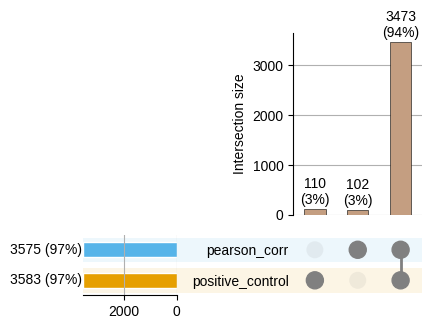

In [83]:
dataset = 'replogle2' #'nakatake' #op'

if dataset == 'op':
    layer = 'pearson'
    perturb_col = 'sm_name'
elif dataset in ['replogle2', 'nakatake']:
    layer = 'X'
    perturb_col = 'perturbation'
else:
    raise ValueError('define first')

par = {
    # 'grn_models': ['pearson_corr', 'positive_control', 'celloracle', 'grnboost2', 'scenicplus'],
    # 'grn_models': ['pearson_corr', 'positive_control', 'scenic', 'grnboost2', 'portia'],
    'grn_models': ['pearson_corr', 'positive_control'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad',
    'layer': layer,
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000
}


exp_objs_dict = {}

for model in par['grn_models']:
    par['grn_model'] = f"{par['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

## Regression 1

In [27]:
# - imports 
sys.path.append('../../task_grn_inference/src/utils')
from task_grn_inference.src.metrics.regression_1.main import main, cross_validation, r2_score, regression_1, process_net

# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par['evaluation_data'])
if par['layer'] == 'X':
    pass
else:
    perturb_data.X = perturb_data.layers[par['layer']]
gene_names = perturb_data.var_names

In [28]:
# - calculate the scores and feature importance 
if False:
    scores_store = []

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par['grn_models']):
                net = pd.read_csv(f"{par['grn_models_dir']}/{model}.csv")
                
                results = cross_validation(net, perturb_data_sub, par={'exclude_missing_genes':False, 'reg_type':reg_type, 'verbose':3, 'num_workers':20})

                reg_models = results['reg_models']
                r2score_samples = results['r2scores']                

                if reg_type == 'ridge':
                    coeffs = [reg.coef_ for reg in reg_models]
                else:
                    coeffs = [reg.get_feature_importance() for reg in reg_models]

                # - mean of feature importance across CVs
                net_mat = process_net(net.copy(), gene_names)
                mean_coeff = pd.DataFrame(
                    np.mean(coeffs, axis=0),
                    columns=net_mat.columns,
                    index=pd.MultiIndex.from_frame(obs[[perturb_col, 'cell_type']])
                )    
                # - normalize feature importance for each sample
                mean_coeff = mean_coeff.abs()
                mean_coeff = mean_coeff.div(mean_coeff.max(axis=1), axis=0)
                
                # - long df for feature importance 
                mean_coeff  = mean_coeff.reset_index()
                mean_coeff = mean_coeff.melt(id_vars=[perturb_col, 'cell_type'], var_name='tf', value_name='feature_importance')
                mean_coeff['model'] = model
                mean_coeff['donor_id'] = donor_id
                mean_coeff['reg_type'] = reg_type

                if i_iter == 0:
                    feature_importance_all = mean_coeff
                else:
                    feature_importance_all = pd.concat([feature_importance_all, mean_coeff], axis=0)

                for i_sample, score_sample in enumerate(r2score_samples):
                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score':score_sample,
                        'model': model,
                        'cell_type': obs.loc[i_sample]['cell_type'],
                        perturb_col: obs.loc[i_sample][perturb_col]
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'../results_folder/{dataset}_scores_store.csv')
    feature_importance_all.to_csv(f'../results_folder/{dataset}_feature_importance.csv')

In [29]:
# - retireive data and subset to one reg type
reg_type = 'ridge'

scores_store_all = pd.read_csv(f'../results_folder/{dataset}_scores_store.csv', index_col=0)
feature_importance_all = pd.read_csv(f'../results_folder/{dataset}_feature_importance.csv', index_col=0)
scores_store = scores_store_all[scores_store_all.reg_type==reg_type]

<Axes: >

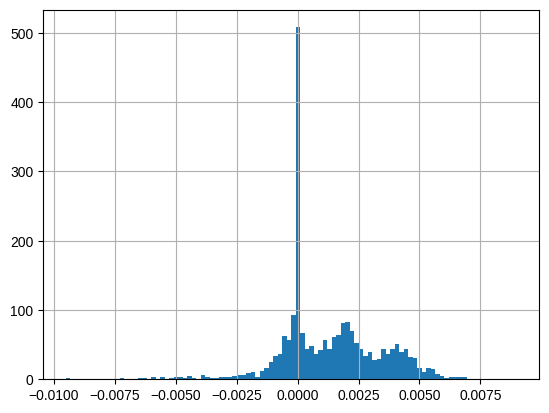

In [30]:
scores_store_all.r2score.hist(bins=100)

### Consistency across donors

In [31]:
if dataset in ['op']:
    # Create a 1x2 subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    # Loop over the regression types and plot each heatmap on a separate subplot
    for idx, reg_type in enumerate(['ridge']):
        # Filter data based on reg_type
        scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]
        
        # Create pivot table
        scores_store_table = scores_store.pivot_table(
            index='donor_id', 
            values='r2score', 
            columns=[col for col in scores_store.columns if col not in ['donor_id', 'r2score']]
        ).fillna(0)
        
        # Calculate the Spearman correlation matrix
        corr_matrix = scores_store_table.T.corr(method='spearman')
        
        # Plot heatmap on the appropriate subplot axis
        sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')

    # Show the plot
    plt.show()

### Similarity in performance across models

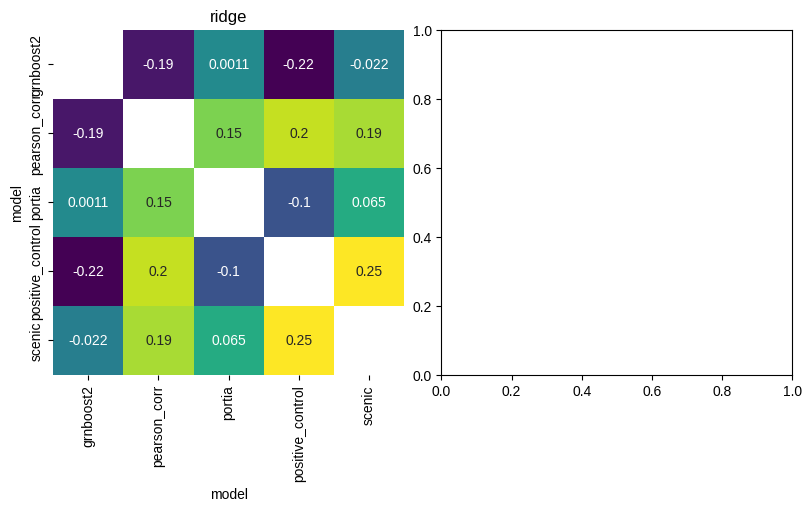

In [32]:
# Create a 1x2 subplot layout for the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)

# Loop over regression types to generate each heatmap on separate subplots
for idx, reg_type in enumerate(['ridge']):
    # Filter data for the current reg_type
    scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]
    if scores_store.shape[0]==0:
        continue
    
    # Create a pivot table using 'model' as the index
    scores_store_table = scores_store.pivot_table(
        index='model', 
        values='r2score', 
        columns=[col for col in scores_store.columns if col not in ['model', 'r2score']]
    ).fillna(0)
    
    # Calculate the Spearman correlation matrix
    spearman_corr = scores_store_table.T.corr(method='spearman')
    
    # Set the diagonal values to NaN for better visualization
    np.fill_diagonal(spearman_corr.values, np.nan)
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{reg_type}')

# Show the plots
plt.show()

### Performance segregated by cell types


In [33]:
if dataset in ['op']:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Loop over regression types to generate each heatmap on separate subplots
    for idx, reg_type in enumerate(['ridge']):
        # Filter data for the current reg_type
        scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]
        
        sns.boxplot(data=scores_store, x="model", y="r2score", hue="cell_type", ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')


### Performacne segragated by PC and NC samples

In [34]:
if dataset in ['op']:
    scores_store_all['controls'] = 'Others'
    mask_pc = scores_store_all.sm_name.isin(['Dabrafenib', 'Belinostat'])
    scores_store_all.loc[mask_pc, 'controls'] = 'PC'
    mask_nc = scores_store_all.sm_name.isin(['Dimethyl Sulfoxide'])
    scores_store_all.loc[mask_nc, 'controls'] = 'NC'

    scores_store_controls = scores_store_all[scores_store_all.sm_name.isin(controls3)]

    # - plot for all cell types
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Loop over regression types to generate each heatmap on separate subplots
    for idx, reg_type in enumerate(['ridge']):
        # Filter data for the current reg_type
        scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]
        
        sns.boxplot(data=scores_store, x="model", y="r2score", hue="controls", ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')

    plt.show()

    # - plot cell type specific 
    g = sns.catplot(
        data=scores_store_controls, 
        x='model', 
        y=r'r2score', 
        hue='cell_type', 
        col='sm_name', 
        kind='box',
        height=3, 
        # width=6, 
        aspect=1.4,
        # palette=colors_cell_type,
        legend_out=True
    )
    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Cell type", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('sm_name = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
    # plt.suptitle(title, y=1.2,  fontsize=12, fontweight='bold')

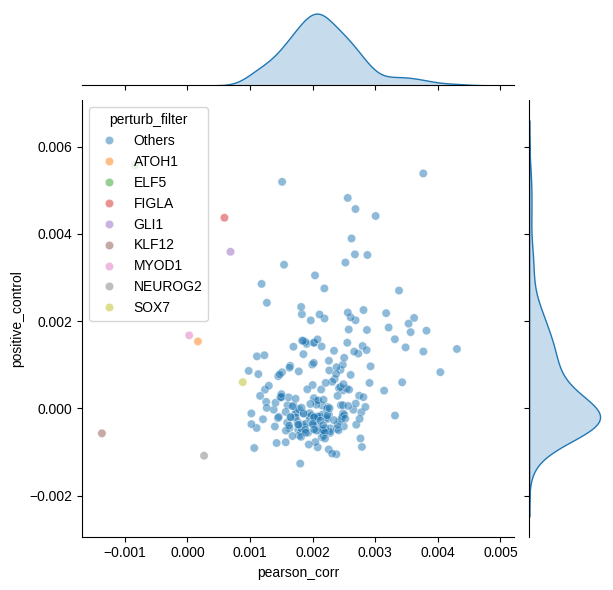

In [37]:
# - joint plot
if dataset == 'op':
    # Aggregate the data to handle duplicates
    subset_df_agg = scores_store.groupby(['sm_name', 'cell_type', 'model'], as_index=False)['r2score'].mean()
    pivot_df = subset_df_agg.pivot(index=['sm_name', 'cell_type'], columns='model', values='r2score')
else:
    subset_df_agg = scores_store.groupby([perturb_col, 'model'], as_index=False)['r2score'].mean()
    pivot_df = subset_df_agg.pivot(index=[perturb_col], columns='model', values='r2score')
    pass


def plot_joint(pivot_df, x_name, y_name):
    
    low_score_compounds = pivot_df[[perturb_col, x_name, y_name]].sort_values(by=[x_name, y_name]).head(8)
    low_score_mask = pivot_df[perturb_col].isin(low_score_compounds[perturb_col])


    pivot_df['perturb_filter'] = 'Others'
    
    pivot_df.loc[low_score_mask, 'perturb_filter'] = pivot_df.loc[low_score_mask, perturb_col]

    sns.jointplot(
        data = pivot_df, 
        x = f"{x_name}", 
        y = f"{y_name}", 
        hue='perturb_filter',   # Color points by "True"/"False"
        # style='cell_type',
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5
    )
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    # plt.legend(loc=(1.3, .2))
plot_joint(pivot_df.reset_index(), x_name=par['grn_models'][0], y_name=par['grn_models'][1])


### Feature importance: similarity across models

In [38]:
# - model specific feature importance -> only intersections 
def lambda_func(df):
    return df['feature_importance'].values.flatten()

feature_importance = feature_importance_all[feature_importance_all.reg_type == reg_type].drop(columns=['reg_type'])
# feature_importance
df_pivot = feature_importance.groupby('model').apply(lambda_func)
df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)
df_pivot.T.corr(method='spearman').style.background_gradient()

/vol/tmp/users/jnourisa/ipykernel_648217/3332936329.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot = feature_importance.groupby('model').apply(lambda_func)


model,grnboost2,pearson_corr,portia,positive_control,scenic
model,,,,,
grnboost2,1.000000,0.008287,-0.026213,0.075499,0.037050
pearson_corr,0.008287,1.000000,-0.008553,0.011051,-0.061570
portia,-0.026213,-0.008553,1.000000,0.066600,0.091535
positive_control,0.075499,0.011051,0.066600,1.000000,0.008983
scenic,0.037050,-0.061570,0.091535,0.008983,1.000000


In [39]:
# - model specific feature importance -> only intersections 
if False:
    def lambda_func(df):
        return df['feature_importance'].values.flatten()
    # for reg_type in ['ridge','GB']:
    # Create a figure with 3 axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Iterate over donor_ids
    for idx, donor_id in enumerate(feature_importance.donor_id.unique()):
        df_pivot = feature_importance[feature_importance.donor_id == donor_id].groupby('model').apply(lambda_func)
        df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)
        
        # Calculate Spearman correlation
        spearman_corr = df_pivot.T.corr(method='spearman')
        np.fill_diagonal(spearman_corr.values, np.nan)
        
        # Plot the heatmap on the respective axis
        sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, vmin=-.5, vmax=.5,
                    ax=axes[idx])
        axes[idx].set_title(f'Spearman Corr - Donor {donor_id}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [40]:
feature_importance_all

,perturbation,cell_type,tf,feature_importance,model,donor_id,reg_type
0,ALX3,cell_type,A1CF,0.140476,pearson_corr,donor_one,ridge
1,ALX3,cell_type,A1CF,0.132258,pearson_corr,donor_one,ridge
2,ALX4,cell_type,A1CF,0.167012,pearson_corr,donor_one,ridge
3,ALX4,cell_type,A1CF,0.138257,pearson_corr,donor_one,ridge
4,ANKRD22,cell_type,A1CF,0.122758,pearson_corr,donor_one,ridge
...,...,...,...,...,...,...,...
90739,THRA,cell_type,ZSCAN5C,0.014607,portia,donor_one,ridge
90740,ZBTB44,cell_type,ZSCAN5C,0.004183,portia,donor_one,ridge
90741,ZBTB44,cell_type,ZSCAN5C,0.003995,portia,donor_one,ridge
90742,ZSCAN5A,cell_type,ZSCAN5C,0.027835,portia,donor_one,ridge


#### Enrichment analysis

In [41]:
# Pivot with pivot_table and take the mean of duplicates
if dataset in ['op']:
    columns = ['model', 'cell_type', perturb_col, 'donor_id']
else:
    columns = ['model',  perturb_col]
feature_importance_common = feature_importance_all.pivot_table(
    index=columns, 
    values='feature_importance', 
    columns='tf',
    aggfunc='mean'  # or 'sum', 'max', etc.
)
feature_importance_common = feature_importance_common.loc[:, ~feature_importance_common.isna().any(axis=0)]
feature_importance_common.head()

tf                         ASCL2      DBX2      DLX4      DLX5     DMRT1  \
model     perturbation                                                     
grnboost2 ALX3          0.089961  0.212983  0.012450  0.029058  0.012761   
          ALX4          0.111748  0.193386  0.004812  0.036633  0.015759   
          ANKRD22       0.111671  0.161881  0.003865  0.048438  0.022512   
          ARID3A        0.097853  0.179938  0.003105  0.047639  0.016388   
          ASCL2         0.078461  0.220472  0.012958  0.032988  0.008421   

tf                          DUXA      E2F6      ELF5      EMX2      ESR2  ...  \
model     perturbation                                                    ...   
grnboost2 ALX3          0.066287  0.038678  0.022571  0.198060  0.149887  ...   
          ALX4          0.081873  0.019085  0.032420  0.239513  0.166544  ...   
          ANKRD22       0.073400  0.019496  0.029886  0.255526  0.182434  ...   
          ARID3A        0.070491  0.020039  0.033317  0.227118  0.158583  ...   
          ASCL2         0.060257  0.028985  0.020754  0.189411  0.134501  ...   

tf                        POU3F2    POU4F2     PPARA    RHOXF2     SOX17  \
model     perturbation                                                     
grnboost2 ALX3          0.014155  0.057840  0.000478  0.083288  0.020357   
          ALX4          0.032103  0.083852  0.003705  0.024005  0.017606   
          ANKRD22       0.060893  0.080647  0.007442  0.004928  0.010832   
          ARID3A        0.042534  0.073913  0.006283  0.002518  0.014308   
          ASCL2         0.036724  0.054666  0.003928  0.049071  0.016648   

tf                         TBX21    TFAP2D      VAX2     ZFP92    ZNF556  
model     perturbation                                                    
grnboost2 ALX3          0.032818  0.229023  0.007797  0.326774  0.070517  
          ALX4          0.035801  0.373918  0.007191  0.345555  0.048424  
          ANKRD22       0.045554  0.364382  0.016703  0.338270  0.062430  
          ARID3A        0.041377  0.337930  0.014972  0.299229  0.061067  
          ASCL2         0.036302  0.348541  0.007699  0.277900  0.055234  

[5 rows x 62 columns]

In [42]:
# - reformat the genesets database
if False:
    panglao_df = pd.read_csv('../output/PanglaoDB_markers_27_Mar_2020.tsv.gz', sep='\t')

    panglao_df = panglao_df[panglao_df.species.isin(['Mm Hs','Hs'])]

    # Open a new file to write the GMT formatted data
    with open("../output/panglaodb_marker_sets.gmt", "w") as gmt_file:
        # Loop through each unique cell type in PanglaoDB
        for cell_type in panglao_df['cell type'].unique():
            # Filter genes for the current cell type
            genes = panglao_df[panglao_df['cell type'] == cell_type]['official gene symbol'].tolist()
            
            # Write the cell type name, description, and genes to the GMT file
            gmt_file.write(f"{cell_type}\tPanglaoDB cell type marker\t" + "\t".join(genes) + "\n")

In [43]:
common_tfs = list(feature_importance_common.columns.to_numpy())

# Perform Over-Representation Analysis (ORA)
enr = gp.enrichr(
    gene_list=common_tfs,     # List of genes
    gene_sets='../output/panglaodb_marker_sets.gmt',  #KEGG_2021_Human 'GO_Biological_Process_2021'
    organism='Human',         # Organism
    outdir='output/enrichr_results', # Output directory
)

enrich_rr = enr.results

enrich_rr = enrich_rr[enrich_rr['Adjusted P-value']<0.05][['Term', 'Overlap', 'Adjusted P-value', 'Genes']]
enrich_rr

,Term,Overlap,Adjusted P-value,Genes
3,Beta cells,4/51,0.010906,NKX6-1;PAX4;PDX1;NEUROD1
36,Neural stem/precursor cells,5/57,0.002214,NEUROG1;DLX5;NEUROD1;NHLH1;ASCL2
51,Trophoblast cells,3/31,0.022386,ELF5;ASCL2;GCM1


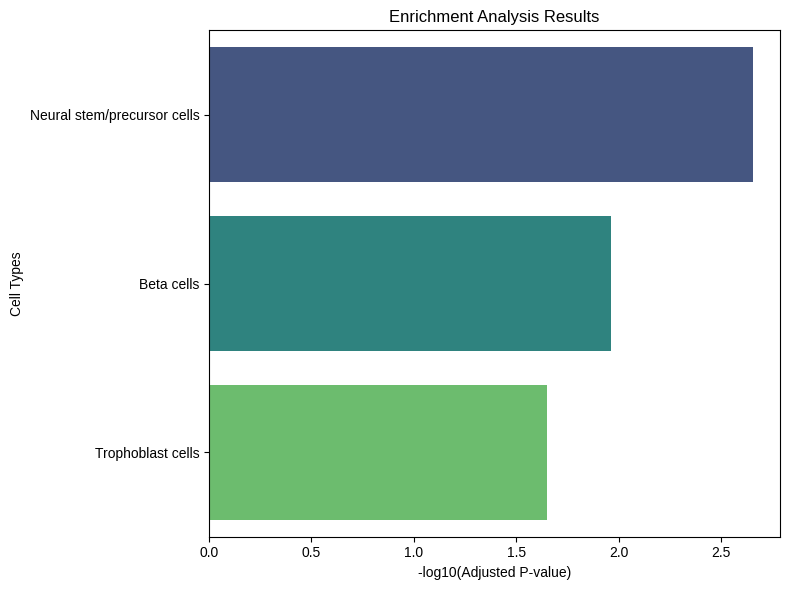

In [44]:
def plot_enrichment(df):
    # Calculate -log10 of Adjusted P-value for a clearer visualization
    df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])

    # Sort the DataFrame by significance (optional)
    df = df.sort_values(by='-log10(Adjusted P-value)', ascending=False)

    # Plotting the enrichment analysis
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, y='Term', x='-log10(Adjusted P-value)', palette="viridis")

    # Add plot labels and title
    plt.xlabel("-log10(Adjusted P-value)")
    plt.ylabel("Cell Types")
    plt.title("Enrichment Analysis Results")
    plt.tight_layout()
plot_enrichment(enrich_rr)
# Show plot
plt.show()

In [45]:
# - get the top features with highest sum across all models
numeric_df = feature_importance_common.select_dtypes(include='number')
mean_values_by_tf = numeric_df.groupby(level='tf', axis=1).mean()
top_5_tfs = mean_values_by_tf.mean().nlargest(5).index
print("Top 5 TFs with highest average values:")
print(top_5_tfs)

Top 5 TFs with highest average values:
Index(['TFAP2D', 'EMX2', 'MYOG', 'RHOXF2', 'HNF4A'], dtype='object', name='tf')


In [46]:
if dataset in ['op']:
    tf = 'BACH2'
    df_one_tf = feature_importance_common[[tf]].reset_index()
    df_one_tf = df_one_tf[df_one_tf.sm_name.isin(controls3)]
    df_one_tf.sm_name = df_one_tf.sm_name.astype(str)

    sns.boxplot(data=df_one_tf, x="model", y=tf, hue="cell_type")
    plt.show()


    g = sns.catplot(
            data=df_one_tf, 
            x='model', 
            y=tf, 
            hue='cell_type', 
            col='sm_name', 
            kind='box',
            height=3, 
            # width=6, 
            aspect=1.4,
            # palette=colors_cell_type,
            legend_out=True
        )
    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Cell type", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('sm_name = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
# plt.suptitle(title, y=1.2,  fontsize=12, fontweight='bold')


In [47]:
# - feature importance variation across control samples 
if False:
    import seaborn as sns
    feature_importance_common = feature_importance[feature_importance.tf.isin(common_tfs)]

    df = feature_importance_common[feature_importance_common.sm_name.isin(controls3[2:3])].drop(columns='sm_name')  # one compound
    df_mean = df.groupby(['model', 'cell_type', 'donor_id', 'tf']).mean()
    df_std = df.groupby(['model', 'cell_type', 'donor_id', 'tf']).std()
    df_var = df_std / df_mean
    df_var.columns=['std2mean']
    df_var = df_var.reset_index()
        
    g = sns.catplot(
            data=df_var, 
            x='model', 
            y='std2mean', 
            hue='cell_type', 
            col='donor_id', 
            kind='box',
            height=4, 
            # width=6, 
            aspect=1.4,
            # palette=colors_cell_type,
            legend_out=True,
            showfliers=False
        )
    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Cell type", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('sm_name = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [48]:
marker_tfs = {
    "B cells": ["PAX5", "EBF1", "SPIB", "IRF4", "IRF8"],
    "T cells": ["FOXP3", "TBX21", "GATA3", "RORC", "TOX"],
    "NK cells": ["TBX21", "EOMES", "IKZF3", "IRF8"],
    "Myeloid cells": ["SPI1", "CEBPA", "IRF8", "RUNX1", "GATA2"]
}
np.intersect1d(marker_tfs['Myeloid cells'], tf_all)

array(['CEBPA', 'GATA2', 'IRF8', 'RUNX1', 'SPI1'], dtype='<U14')

In [49]:
aaaa

NameError: name 'aaaa' is not defined

## Regression 2

In [84]:
# - imports 
sys.path.append('../../task_grn_inference/src/utils')
from task_grn_inference.src.metrics.regression_2.main import *
# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par['evaluation_data'])
gene_names = perturb_data.var_names
perturb_data

AnnData object with n_obs × n_vars = 2072 × 8244
    obs: 'perturbation', 'is_control', 'is_test', 'perturbation_type'

In [86]:
# - calculate the scores and feature importance 
if True:
    #- create consensuns
    from task_grn_inference.src.metrics.consensus.script import main
    par['models'] = par['grn_models']
    par['models_dir'] = par['grn_models_dir']
    main(par)

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'


    # - run reg
    scores_store = []

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par['grn_models']):
                net = pd.read_csv(f"{par['grn_models_dir']}/{model}.csv")
                
                net_matrix = net_to_matrix(net, gene_names, par)

                n_cells = perturb_data_sub.shape[0]
                random_groups = np.random.choice(range(1, 5+1), size=n_cells, replace=True) # random sampling
                groups = LabelEncoder().fit_transform(random_groups)

                # Load and standardize perturbation data
                layer = par['layer']
                if  layer=='X':
                    X = perturb_data_sub.X
                else:
                    X = perturb_data_sub.layers[layer]
                
                try:
                    X = X.todense().A
                except:
                    pass

                X = RobustScaler().fit_transform(X)

                # Load consensus numbers of putative regulators
                with open(par['consensus'], 'r') as f:
                    data = json.load(f)
                gene_names_ = np.asarray(list(data.keys()), dtype=object)
                n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}

                n_features_theta_median = np.asarray([data[gene_name]['0.5'] for gene_name in gene_names], dtype=int)

                # Load list of putative TFs
                tf_names = np.loadtxt(par['tf_all'], dtype=str)
                if par['apply_tf']==False:
                    tf_names = gene_names

                rr_all = cross_validate(reg_type, gene_names, tf_names, X, groups, net_matrix, n_features_theta_median, n_jobs=par['num_workers'])

                r2_scores = np.asarray([rr_all['results'][j]['avg-r2'] for j in range(len(rr_all['results']))])
                mean_r2_scores = np.mean(r2_scores)

                print(mean_r2_scores)
                
                for i_gene, gene in enumerate(rr_all['gene_names']):
                    present = gene in net.target.unique()
                    r2score = rr_all['results'][i_gene]['avg-r2']
                    
                    reg_models = rr_all['results'][i_gene]['models']

                    # if False: # skip feature importance for now
                    if reg_type == 'ridge':
                        coeffs = [reg.coef_ for reg in reg_models]
                    else:
                        coeffs = [reg.get_feature_importance() for reg in reg_models]
                    coeffs = np.asarray(coeffs)

                    n_regulator = coeffs.shape[1]

                    if len(coeffs)==0:
                        feature_importance_mean2std = 0
                    else:
                        feature_importance_mean2std = np.abs(np.mean(coeffs, axis=0)/np.std(coeffs, axis=0)).mean()
                    # print(feature_importance_mean2std)

                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score': r2score,
                        'present':present,
                        'model': model,
                        'gene': gene,
                        'n_regulator': n_regulator,
                        'feature_importance_mean2std': feature_importance_mean2std
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'../results_folder/{dataset}_reg2_scores_store.csv')
    # feature_importance_all.to_csv('../results_folder/reg2_feature_importance.csv')

{'grn_models': ['pearson_corr', 'positive_control'], 'grn_models_dir': '../../task_grn_inference/resources/grn_models/replogle2/', 'evaluation_data': '../../task_grn_inference/resources/evaluation_datasets/replogle2_perturbation.h5ad', 'layer': 'X', 'consensus': '../output/replogle2_consensus-num-regulators.json', 'tf_all': '../../task_grn_inference/resources/prior/tf_all.csv', 'static_only': False, 'num_workers': 4, 'apply_tf': True, 'apply_skeleton': False, 'verbose': 2, 'max_n_links': 50000, 'grn_model': '../../task_grn_inference/resources/grn_models/replogle2//positive_control.csv', 'models': ['pearson_corr', 'positive_control'], 'models_dir': '../../task_grn_inference/resources/grn_models/replogle2/'}
Sparsity of ../../task_grn_inference/resources/grn_models/replogle2/pearson_corr.csv: 0.9992643113801495
Sparsity of ../../task_grn_inference/resources/grn_models/replogle2/positive_control.csv: 0.9992643113801495


GRN preprocessing: 8244it [00:00, 45514.05it/s]
ridge CV: 100%|██████████| 8244/8244 [01:25<00:00, 96.71it/s] 


0.09719331597260066


GRN preprocessing: 8244it [00:00, 42541.48it/s]
ridge CV: 100%|██████████| 8244/8244 [01:11<00:00, 114.96it/s]


0.10000551875659398


In [88]:
# - retreive regresion results
scores_store = pd.read_csv(f'../results_folder/{dataset}_reg2_scores_store.csv', index_col=0)

<Axes: xlabel='model', ylabel='feature_importance_mean2std_log'>

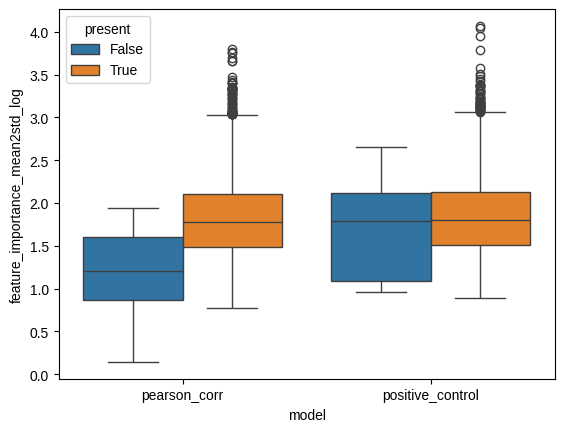

In [89]:
# - random choice of regulators versus informed 
scores_store['feature_importance_mean2std_log'] = np.log1p(scores_store['feature_importance_mean2std'])
sns.boxplot(scores_store, x = 'model', y='feature_importance_mean2std_log', hue='present')

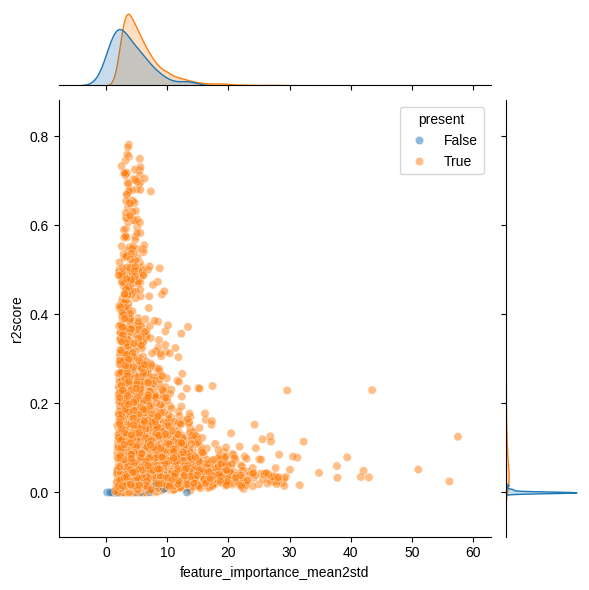

In [90]:
sns.jointplot(
        data = scores_store, 
        x = 'feature_importance_mean2std', 
        y = 'r2score', 
        hue= 'present',   # Color points by "True"/"False"
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5
    )

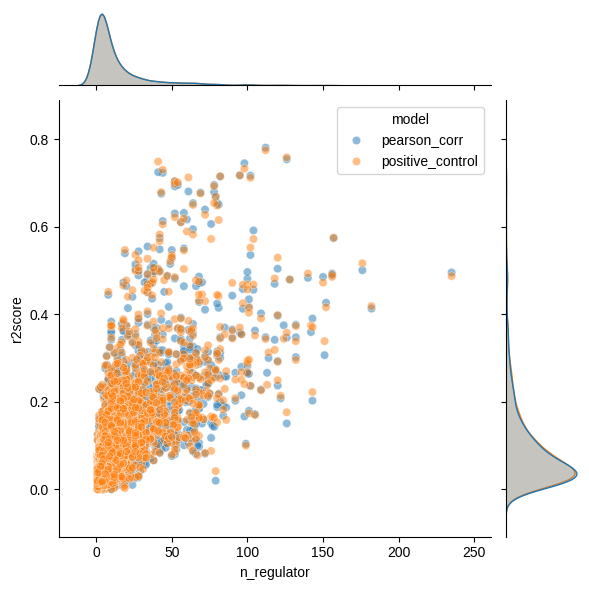

In [91]:
sns.jointplot(
        data = scores_store, 
        x = 'n_regulator', 
        y = 'r2score', 
        hue= 'model',   # Color points by "True"/"False"
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5
    )

In [56]:
# - consistency in r2 scores among donors
if dataset in ['op']:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    # Loop over the regression types and plot each heatmap on a separate subplot
    for idx, reg_type in enumerate(['ridge']):
        # Create pivot table
        scores_store_table = scores_store.pivot_table(
            index='donor_id', 
            values='r2score', 
            columns=[col for col in scores_store.columns if col not in ['donor_id', 'r2score']]
        ).fillna(0)
        
        # Calculate the Spearman correlation matrix
        corr_matrix = scores_store_table.T.corr(method='spearman')
        
        # Plot heatmap on the appropriate subplot axis
        sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')

    # Show the plot
    plt.show()


In [93]:
# - corr of scores across models
scores_store.pivot(index='model', columns='gene', values='r2score').T.corr()

model,pearson_corr,positive_control
model,,
pearson_corr,1.000000,0.992917
positive_control,0.992917,1.000000


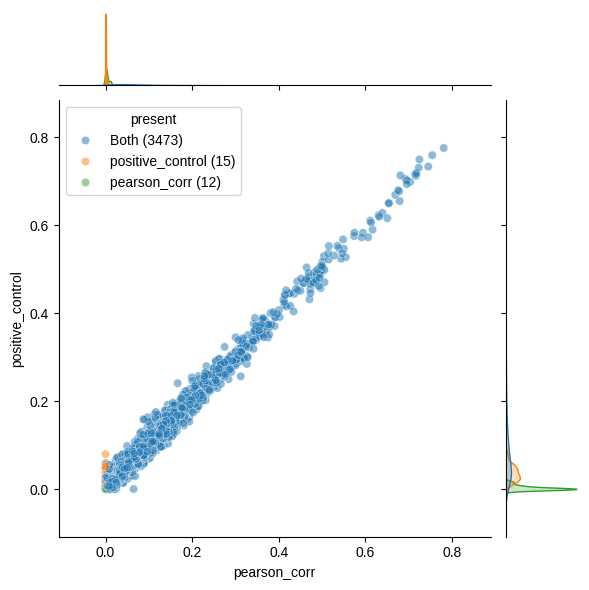

In [94]:
def plot_joint_gene_scores(method1, method2):
    
    scores_store_table = scores_store.pivot_table(index='gene', columns='model', values='r2score', aggfunc='mean')

    # - add common gene specs 
    present_table = scores_store.pivot_table(index='gene', columns='model', values='present', aggfunc='mean')
    present_table = present_table.astype(bool)

    scores_store_table['present'] = 'None'
    scores_store_table.loc[present_table[method1], 'present'] = method1
    scores_store_table.loc[present_table[method2], 'present'] = method2
    scores_store_table.loc[present_table[method1]&present_table[method2], 'present'] = 'Both'


    for name in ['None', method1, method2, 'Both']:
        mask = scores_store_table['present'] == name
        n = (mask).sum()
        scores_store_table.loc[mask, 'present'] += f' ({n})'

    sns.jointplot(
            data = scores_store_table, 
            x = method1, 
            y = method2, 
            hue= 'present',   # Color points by "True"/"False"
            # markers=True,
            # kind="kde",    # Contours with kde
            # fill=False,    # Fill contour lines
            marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
            alpha=.5
        )
    return scores_store_table
scores_store_table = plot_joint_gene_scores(par['grn_models'][0], par['grn_models'][1])


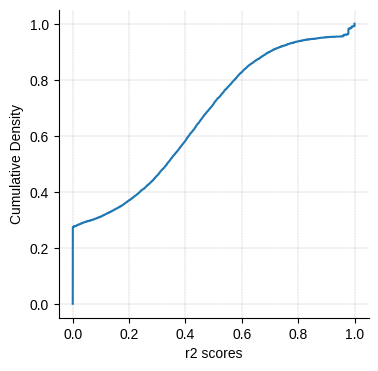

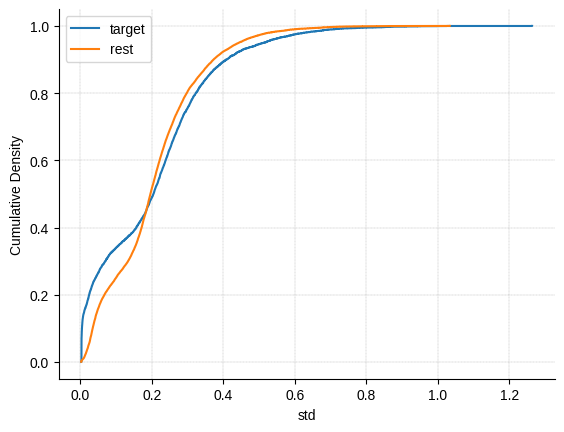

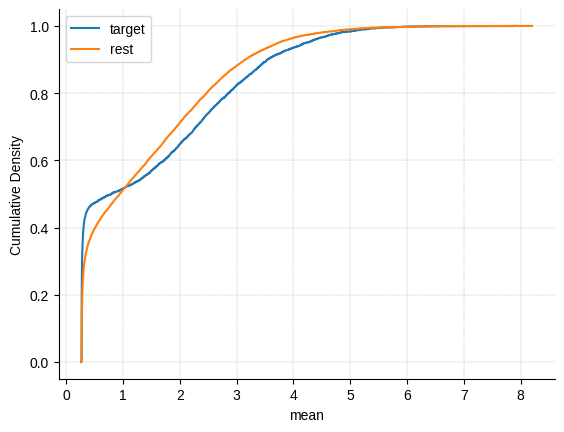

In [59]:
# - evaluation of common genes
common_genes_all = interaction_info['target'][interaction_info['target'].all(axis=1)].index
mask_genes = perturb_data.var_names.isin(common_genes_all)
X_target = perturb_data.X[:, mask_genes]
X_rest = perturb_data.X[:, ~mask_genes]

plot_cumulative_density(scores_store[scores_store.gene.isin(common_genes_all)].r2score, x_label='r2 scores')


fig, ax = plt.subplots(1,1)
plot_cumulative_density(np.std(X_target, axis=0), ax=ax, label='target', x_label='std')
plot_cumulative_density(np.std(X_rest, axis=0), ax=ax, label='rest',x_label='std')
plt.legend()

fig, ax = plt.subplots(1,1)
plot_cumulative_density(np.mean(X_target, axis=0), ax=ax, label='target', x_label='mean')
plot_cumulative_density(np.mean(X_rest, axis=0), ax=ax, label='rest',x_label='mean')
plt.legend()


	1.	Gene Ontology (GO) and Pathway Enrichment Analysis: Perform enrichment analysis to identify biological processes, molecular functions, or cellular components that are overrepresented among these genes. Tools like DAVID, GSEA, or Enrichr can help reveal common functional themes.
	2.	Expression Patterns: Check if these genes exhibit similar expression patterns, possibly across specific cell types, tissues, or conditions. Clustering or co-expression analysis might show if these genes are regulated together or are part of similar pathways.
	3.	Regulatory Elements and Transcription Factors (TFs): Investigate shared regulatory elements or transcription factors that may control these genes. This can be done using tools like TF-binding motif enrichment or databases like TRANSFAC or JASPAR.
	4.	Functional Annotation and Known Gene Sets: Use databases such as MSigDB or KEGG to identify if these genes belong to known gene sets related to particular biological processes, disease states, or cellular responses.
	5.	Network Analysis: Build a gene network to see if these predictive genes are highly interconnected or co-regulated. You could look for hubs or clusters within the network to identify core functional modules.
	6.	Genomic Features: Analyze commonalities in genomic characteristics such as gene length, GC content, or chromosomal location, which might give insights into structural similarities.

By combinin

In [52]:
# - enrichment analysiss
enr = gp.enrichr(gene_list=list(common_genes_all),
                 gene_sets= ['TRANSFAC_and_JASPAR_PWMs'], #,['GO_Biological_Process_2021', 'KEGG_2021_Human'], MSigDB_Hallmark_2020, PanglaoDB_Augmented_2021, ChEA_2016
                 organism='Human',  # change to 'Mouse' or other organism if needed
                 outdir=None)  # No output files

# View results as a DataFrame
results_df = enr.results

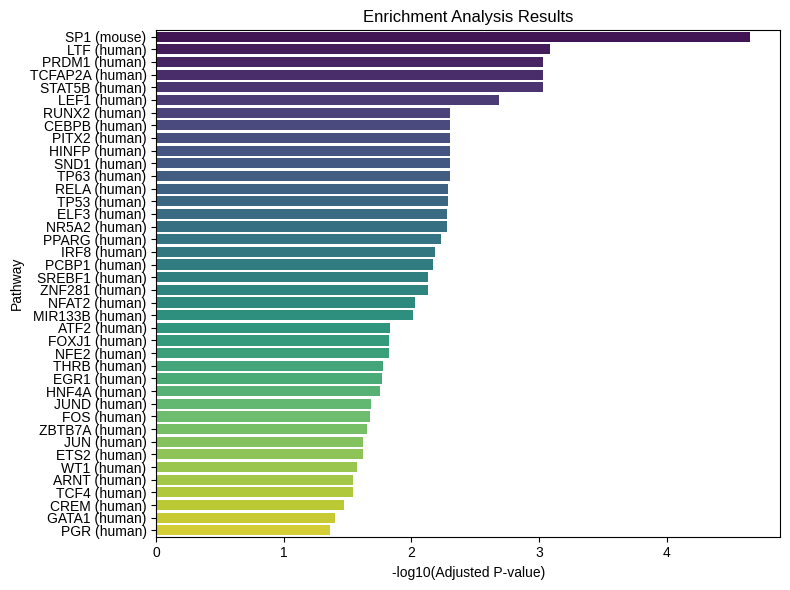

In [53]:
def plot_enrichment(df):
    # Calculate -log10 of Adjusted P-value for a clearer visualization
    df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
    

    # Sort the DataFrame by significance (optional)
    df = df.sort_values(by='-log10(Adjusted P-value)', ascending=False)

    # Plotting the enrichment analysis
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, y='Term', x='-log10(Adjusted P-value)', palette="viridis")

    # Add plot labels and title
    plt.xlabel("-log10(Adjusted P-value)")
    plt.ylabel("Pathway")
    plt.title("Enrichment Analysis Results")
    plt.tight_layout()
df = results_df[results_df['Adjusted P-value']<.05]
df = df.sort_values(by='Adjusted P-value', ascending=True)[:40]
# print(df)
plot_enrichment(df)

In [54]:
if False:
    # - mean of feature importance across CVs
    mean_coeff = pd.DataFrame(
        np.mean(coeffs, axis=0),
        columns=net_mat.columns,
        index=pd.MultiIndex.from_frame(obs[['sm_name', 'cell_type']])
    )    
    # - normalize feature importance for each sample
    mean_coeff = mean_coeff.abs()
    mean_coeff = mean_coeff.div(mean_coeff.max(axis=1), axis=0)

    # - long df for feature importance 
    mean_coeff  = mean_coeff.reset_index()
    mean_coeff = mean_coeff.melt(id_vars=['sm_name', 'cell_type'], var_name='tf', value_name='feature_importance')
    mean_coeff['model'] = model
    mean_coeff['donor_id'] = donor_id
    mean_coeff['reg_type'] = reg_type

In [55]:
main(par={
  "evaluation_data": f"{task_grn_inference_dir}/resources/evaluation_datasets/op_perturbation.h5ad",
  "tf_all": f"{task_grn_inference_dir}/resources/prior/tf_all.csv",
  # "prediction": "output/pearson_net.csv",
  "prediction": f"{task_grn_inference_dir}/resources/grn_models/op/pearson_corr.csv",
  "method_id": "scenic",
  "max_n_links": 50000,
  "apply_tf": False,
  'score': 'output/score.h5ad',
  'reg_type': 'ridge',
  'layer': 'pearson',
  'subsample': -1,
  'num_workers': 4,
  'skeleton': 'resources/prior/skeleton.csv',
  'apply_skeleton': False,
  'verbose': 4,
  'binarize': True
})

{'evaluation_data': '../../task_grn_inference/resources/evaluation_datasets/op_perturbation.h5ad', 'tf_all': '../../task_grn_inference/resources/prior/tf_all.csv', 'prediction': '../../task_grn_inference/resources/grn_models/op/pearson_corr.csv', 'method_id': 'scenic', 'max_n_links': 50000, 'apply_tf': False, 'score': 'output/score.h5ad', 'reg_type': 'ridge', 'layer': 'pearson', 'subsample': -1, 'num_workers': 4, 'skeleton': 'resources/prior/skeleton.csv', 'apply_skeleton': False, 'verbose': 4, 'binarize': True}


KeyError: 'models'

- sample based and gene based predictions scores, for reg1 and 2, respectively -> three top models
- feature activation for different CVs. sample based and gene 
- variability across donors 
- different alphas


### Feature importance analysis


# Build exp models

In [13]:
file_name = 'norman' #'op', nakatake, adamson
par = {
    
        'grn_models': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus'],
        # 'grn_models': [ 'positive_control', 'pearson_corr', 'grnboost2', 'scenicplus', 'celloracle'],

        'peak_gene_models': ['celloracle', 'scenicplus', 'figr', 'granie'],
        'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{file_name}/',
        'peak_gene_dir': f'{task_grn_inference_dir}/resources/grn_models/{file_name}/peak_gene/',
}

exp_objs_dict = {}
nets_dict = {}

for model in par['grn_models']:
    par['grn_model'] = f"{par['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par['grn_model'])
    
    nets_dict[model] = net

    if model in par['peak_gene_models']:
        peak_gene_net = pd.read_csv(f"{par['peak_gene_dir']}/{model}.csv")
    else:
        peak_gene_net = None
    print(model, len(net))
    obj = Exp_analysis(net, peak_gene_net)
    obj.calculate_basic_stats()
    obj.calculate_centrality()

    exp_objs_dict[model] = obj
exp_objs_dict = {surragate_names[key]:value for key,value in exp_objs_dict.items()}

collectri  is skipped
negative_control  is skipped
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 2182
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped


# General stats

In [14]:
# regulatory links
links_n = {}
source_n = {}
target_n = {}
ratio_positive_negative_dict = {}
nets = {}

gene_names = ad.read_h5ad(f'{task_grn_inference_dir}/resources/inference_datasets/op_rna.h5ad').var_names

for name, obj in exp_objs_dict.items():
    net = obj.net
    nets[name] = net
    if 'cell_type' in net.columns: # for cell specific grn models, take the mean
        n_grn = net.groupby('cell_type').size().mean()
    else:
        n_grn = len(net)

    links_n[name] = n_grn
    source_n[name] = obj.stats['n_source']
    target_n[name] = obj.stats['n_target']
    ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']

In [15]:
color_map_methods = {key:color for key, color in zip(exp_objs_dict.keys(), sns.color_palette('Set2', len(exp_objs_dict.keys())))}

# Assign each method a different linestyle
import itertools
line_styles = ['-', '--', '-.', ':']
linestyle_map_methods = {key: linestyle for key, linestyle in zip(exp_objs_dict.keys(), itertools.cycle(line_styles))}

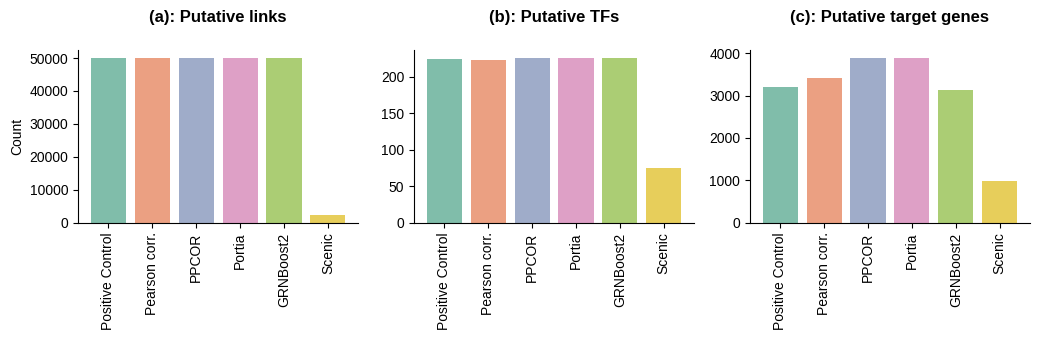

In [16]:
# Prepare data for plotting
data = {
    'Model': [],
    'Count': [],
    'Type': []
}

# Populate the data dictionary for each metric
for model in links_n.keys():
    data['Model'].append(model)
    data['Count'].append(links_n[model])
    data['Type'].append('Putative links')

for model in source_n.keys():
    data['Model'].append(model)
    data['Count'].append(source_n[model])
    data['Type'].append('Putative TFs')

for model in target_n.keys():
    data['Model'].append(model)
    data['Count'].append(target_n[model])
    data['Type'].append('Putative target genes')

# Create a DataFrame from the data dictionary
df = pd.DataFrame(data)

# Create the FacetGrid for separate y-axes
g = sns.FacetGrid(df, col='Type', height=3.5, aspect=1, sharey=False)

# Map the bar plot to each facet
g.map_dataframe(sns.barplot, x='Model', hue='Model', y='Count', palette=color_map_methods, alpha=0.9)

# Customize the plot
g.set_xticklabels(rotation=90)
g.set_axis_labels("", "Count")
# g.fig.suptitle("Gene Regulatory Network Statistics", y=1.05)

# Use ax.margins to set margins on the x-axis
for ax in g.axes.flat:
    ax.margins(x=0.05)  # Adjust the margin fraction as needed

# Remove the default titles and set custom titles without 'Type='
prefixes = ['(a)', '(b)', '(c)']
for i, ax in enumerate(g.axes.flat):
    title = ax.get_title().replace('Type = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
    ax.set_title(title, pad=20, fontsize=12, fontweight='bold')

# Remove spines for better aesthetics
for ax in g.axes.flat:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/stats_{file_name}.png', dpi=300, transparent=True)

In [17]:
if file_name in ['op']:
        # peaks
    peaks_dict = {}
    peaks_n_dict = {}
    for name, obj in exp_objs_dict.items():
        if obj.peak_gene_net is None:
            continue 
        df = obj.peak_gene_net
        print(name)
        try:
            peaks_dict[name] = df.peak.unique()
            peaks_n_dict[name] = df.peak.nunique()
        except:
            peaks_dict[name] = df.source.unique()
            peaks_n_dict[name] = df.source.nunique()
        df = pd.DataFrame({
    'Model': peaks_n_dict.keys(),
    'Count': peaks_n_dict.values()
    })

    # Plot with Seaborn
    plt.figure(figsize=(2.5, 3))
    ax = sns.barplot(x='Model', hue='Model', y='Count', data=df, palette=color_map_methods, alpha=0.6)

    # Customize labels and ticks
    ax.set_ylabel('Count')
    ax.set_title('(d) CREs', pad=20,fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=90)

    ax.margins(x=0.1)

    # Remove top and right spines
    sns.despine(ax=ax, top=True, right=True)

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{results_folder}/explanatory_analysis/figs/stats_cres_{file_name}.png', dpi=300, transparent=True)

#### Regulatory signs

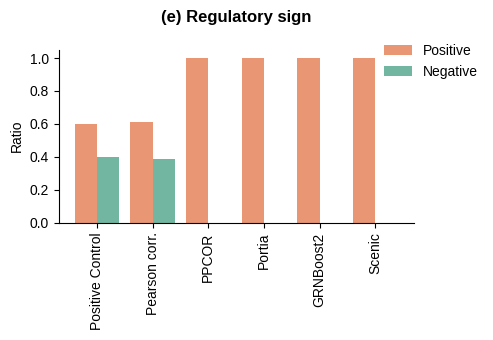

In [18]:
data = ratio_positive_negative_dict
models = list(data.keys())
positive_r = [p for p in data.values()]
negative_r = [1 - p for p in data.values()]


df = pd.DataFrame({
    'Model': models * 2,  # Repeat model names for both Positive and Negative
    'Ratio': positive_r + negative_r,  # Concatenate positive and negative ratios
    'Regulatory Sign': ['Positive'] * len(models) + ['Negative'] * len(models)  # Label each as Positive or Negative
})

# Set Seaborn theme
# sns.set(style="whitegrid")  


# Create bar plot using Seaborn
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
sns.barplot(x='Model', y='Ratio', hue='Regulatory Sign', data=df, width=.8,
            palette=[list(color_map_methods.values())[1], list(color_map_methods.values())[0]], ax=ax)

# Customize labels and ticks
ax.set_ylabel('Ratio')
ax.tick_params(axis='x', rotation=90)
ax.margins(x=0.05)
ax.set_xlabel('')
ax.set_title('(e) Regulatory sign', pad=20, fontsize=12, fontweight='bold')


# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Grid and legend
# ax.grid(alpha=0.3, linestyle='--', linewidth=.5, color='grey')
ax.legend(frameon=False, loc=(.9, .8))
plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/regulatory_signs_{file_name}.png', dpi=300, transparent=True)


### CDF

In [19]:
# # tf gene: in degree
# fig, axes = plt.subplots(1, 4, figsize=(12, 2.5))
# for i_plot, (name, obj) in enumerate(exp_objs_dict.items()):
#     if i_plot < 3:
#         ax = axes[0]
#     elif i_plot < 6:
#         ax = axes[1]
#     elif i_plot < 9:
#         ax = axes[2]
#     else:
#         ax = axes[3]
#     obj.plot_grn_cdf(ax)
#     ax.lines[-1].set_label(name)
#     ax.legend(frameon=False)
#     # ax.set_xlim([-.02,.3])
#     # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
# plt.tight_layout()

# Jaccard similarity 

In [20]:
if 'CollectRI' in nets:
    del nets['CollectRI']
if 'Negative Control' in nets:
    del nets['Negative Control']
if 'GRaNIE' in nets:
    del nets['GRaNIE']
if 'PPCOR' in nets:
    del nets['PPCOR']

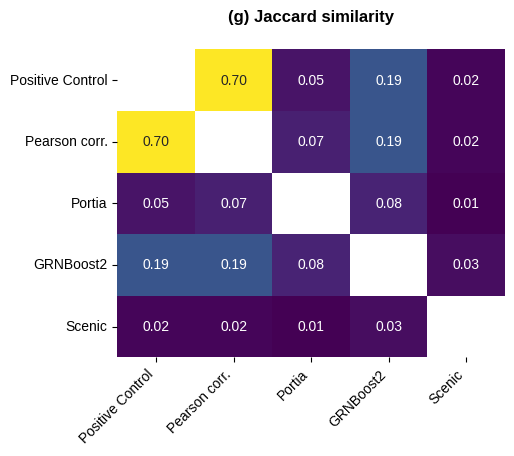

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
_ = jaccard_similarity_net(nets, ax=ax)
ax.set_title('(g) Jaccard similarity', pad=20, fontsize=12, fontweight='bold')
plt.savefig(f'{results_folder}/explanatory_analysis/figs/jaccard_similarity_{file_name}.png', dpi=300, transparent=True, bbox_inches='tight')


In [22]:
aaa

NameError: name 'aaa' is not defined

# Skeleton

In [41]:
skeleton =  pd.read_csv(f'{task_grn_inference_dir}/resources/prior/skeleton.csv')
skeleton_promotor = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/skeleton_promotor.csv')

In [60]:
skeleton_promotor['link'] = skeleton_promotor['source'] + '_' + skeleton_promotor['target']

In [48]:
links_promotor = ['_'.join(link.split(',')[1:]) for link in skeleton_promotor]
links_skeleton = ['_'.join(link.split(',')[1:]) for link in skeleton]

In [70]:
ratio_in_skeleton_dict = {}
ratio_in_promotor_dict = {}

for name, obj in exp_objs_dict.items():
    # skeleton 
    net = obj.net[obj.net.target.isin(gene_names)]
    matches = pd.merge(net[['source', 'target']], skeleton[['source', 'target']], 
                   on=['source', 'target'], how='inner')
    in_count = len(matches)
    ratio_in_skeleton_dict[name] = in_count/len(net)
    # promotor 
    matches = pd.merge(net[['source', 'target']], skeleton_promotor[['source', 'target']], 
                   on=['source', 'target'], how='inner')
    in_count = len(matches)
    ratio_in_promotor_dict[name] = in_count/len(net)

KeyboardInterrupt: 

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_96102/1426171357.py:18: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  g = sns.barplot(x='Model', y='Ratio', hue='Skeleton Status', data=df, width=.8,


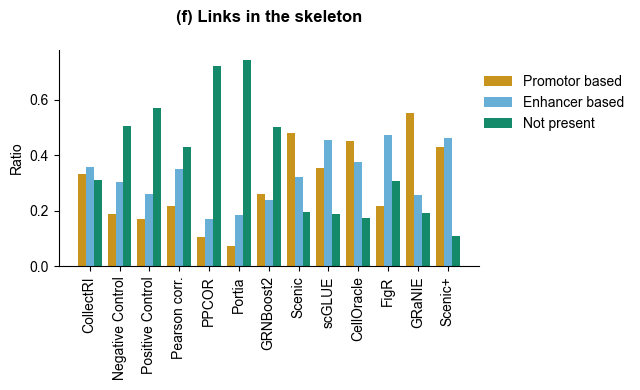

In [69]:
colors = sns.color_palette()
# Data preparation
models = list(ratio_in_skeleton_dict.keys())
in_promotor_r = [p for p in ratio_in_promotor_dict.values()]
in_skeleton_r = [p for p in ratio_in_skeleton_dict.values()]
in_enhancer_r = list(np.array(in_skeleton_r)-np.array(in_promotor_r))
not_in_skeleton_r = [1 - p for p in ratio_in_skeleton_dict.values()]

# Create a DataFrame suitable for Seaborn
df = pd.DataFrame({
    'Model': models * 3,  # Repeat model names for both 'In skeleton' and 'Not in skeleton'
    'Ratio': in_promotor_r + in_enhancer_r + not_in_skeleton_r ,  # Concatenate the positive and negative ratios
    'Skeleton Status': ['Promotor based'] * len(models) +  ['Enhancer based'] * len(models) + ['Not present'] * len(models)  # Label for each bar
})

# Create bar plot using Seaborn
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
g = sns.barplot(x='Model', y='Ratio', hue='Skeleton Status', data=df, width=.8,
            palette=colors_blind, ax=ax)

# Customize labels and ticks
ax.set_ylabel('Ratio')
ax.tick_params(axis='x', rotation=90)

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Grid and legend
ax.legend(frameon=False, loc=(1, .6))
g.axes.margins(x=0.05)
g.axes.set_xlabel('')
ax.set_title('(f) Links in the skeleton', pad=20, fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/in_skeleton.png', dpi=300, transparent=True)


# Connectivity

#### Centrality

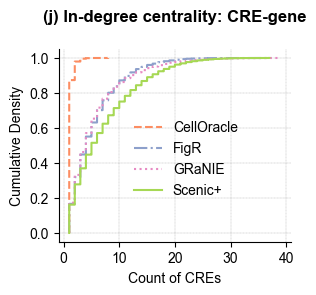

In [17]:
if True:
    # peak gene: in degree
    fig, ax = plt.subplots(figsize=(3, 2.5))
    for name, obj in exp_objs_dict.items():
        if obj.peak_gene_net is None:
            continue 
        
        values = exp_objs_dict[name].peak_gene.in_deg.degree.values
        obj.plot_cumulative_density(values, title=name, x_label='Count of CREs', ax=ax, linestyle=linestyle_map_methods[name], c=color_map_methods[name], alpha=1, label=name)
    ax.legend(frameon=False,  loc=(.3, .2))
    ax.set_title('(j) In-degree centrality: CRE-gene', pad=20, fontsize=12, fontweight='bold')
    
    fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_peakgene_{file_name}.png', dpi=300, transparent=True,  bbox_inches='tight')



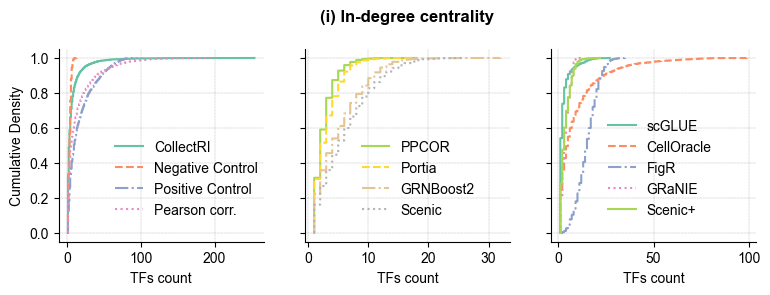

In [18]:
# tf gene: in degree
fig, axes = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)
for i_plot, (name, obj) in enumerate(exp_objs_dict.items()):
    obj.calculate_centrality()
    values = obj.tf_gene.in_deg.degree.values
    if i_plot < 4:
        ax = axes[0]
    elif i_plot < 8:
        ax = axes[1]
    else:
        ax = axes[2]
    obj.plot_cumulative_density(values, title='', x_label='TFs count', ax=ax, alpha=1, label=name, s=5, c=color_map_methods[name], linestyle=linestyle_map_methods[name])
    if i_plot > 4:
        ax.set_ylabel('')
    ax.legend(frameon=False, loc=(.25, .1))
    # ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
# plt.tight_layout()
axes[1].set_title('(i) In-degree centrality', pad=20, fontsize=12, fontweight='bold')

fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_in_{file_name}.png', dpi=300, transparent=True,  bbox_inches='tight')

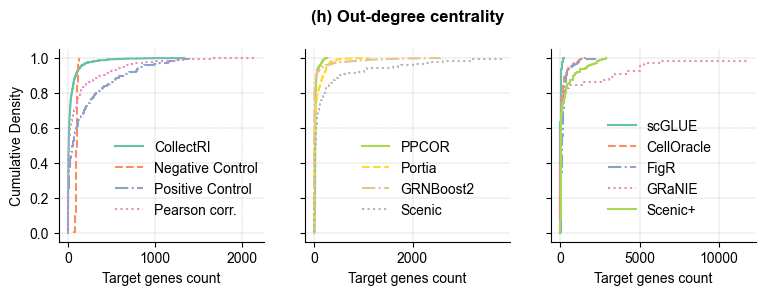

In [19]:
# tf gene: in degree
fig, axes = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)
for i_plot, (name, obj) in enumerate(exp_objs_dict.items()):
    obj.calculate_centrality()
    values = obj.tf_gene.out_deg.degree.values
    if i_plot < 4:
        ax = axes[0]
    elif i_plot < 8:
        ax = axes[1]
    else:
        ax = axes[2]
    obj.plot_cumulative_density(values, title='', x_label='Target genes count', ax=ax, alpha=1, label=name, s=5, c=color_map_methods[name], linestyle=linestyle_map_methods[name])
    if i_plot > 4:
        ax.set_ylabel('')
    ax.legend(frameon=False, loc=(.25, .1))
    # ax.set_xlim([-.02,.3])
    # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
# plt.tight_layout()
axes[1].set_title('(h) Out-degree centrality', pad=20, fontsize=12, fontweight='bold')
fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_out_{file_name}.png', dpi=300, transparent=True,  bbox_inches='tight')

# Intersection of GRN elements

['GRNBoost2', 'CellOracle', 'Pearson corr.', 'Positive Control', 'Scenic+']
['Scenic+', 'GRNBoost2', 'CellOracle', 'Pearson corr.', 'Positive Control']


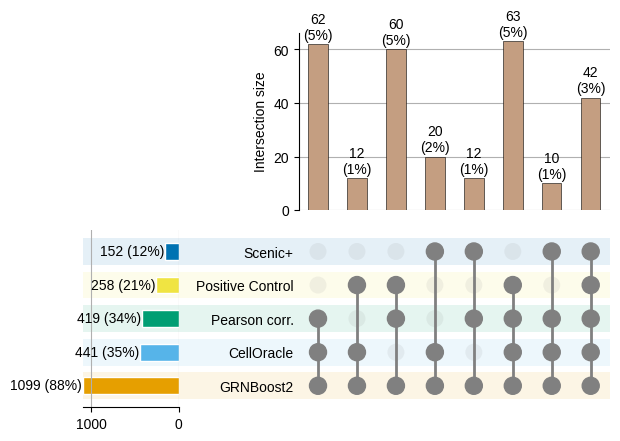

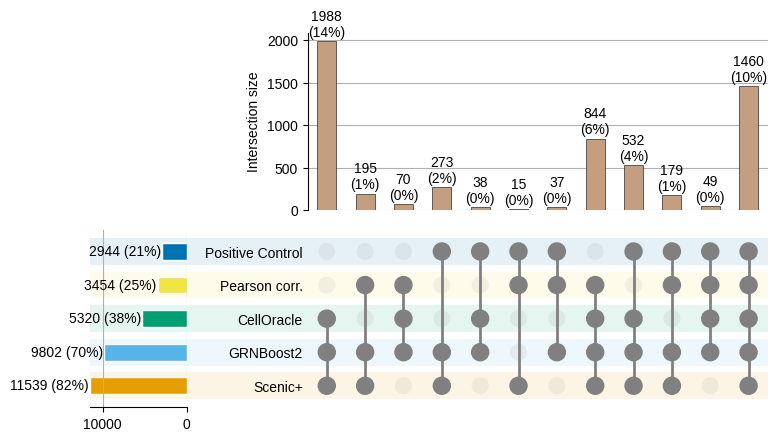

In [43]:
# Create a set of all unique genes
if False:
    # interaction_info = create_interaction_info({key:exp_objs_dict[key] for key in ['Scenic+', 'GRNBoost2', 'Positive Control']})
    interaction_info = create_interaction_info(exp_objs_dict)
    # fig = plot_interactions(interaction_info['links'], min_subset_size = 1000, min_degree=3, color_map=None)    
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/links_interactions.png', dpi=300, transparent=True,  bbox_inches='tight')
    fig = plot_interactions(interaction_info['source'], min_subset_size = 10, min_degree=3, color_map=None) 
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/TFs_interactions.png', dpi=300, transparent=True, bbox_inches='tight')
    fig = plot_interactions(interaction_info['target'], min_subset_size = 10, min_degree=3, color_map=None) 
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/targets_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

In [21]:
aaa

NameError: name 'aaa' is not defined

# Annoation

### Annotate peaks

In [63]:
annotation_df = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_dict.items():
    obj.annotate_peaks(annotation_df)

Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Not all peaks in the net is among the annotated ones. Finding the overlap


#### Plot

In [65]:
annotation_dict = {}
for name, obj in exp_objs_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

,Promoter,Intron,Distal Intergenic,Exon,3' UTR,Downstream (<=300)
CellOracle,98.5,0.6,0.3,0.2,0.1,0.0
FigR,30.4,37.8,18.0,6.7,4.7,1.5
GRaNIE,66.2,15.8,10.4,4.0,2.3,0.9
Scenic+,35.1,34.4,17.3,6.8,4.4,1.2


In [115]:
peak_annotation_df = peak_annotation_df.reindex(['FigR', 'CellOracle', 'GRaNIE', 'Scenic+'])

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),


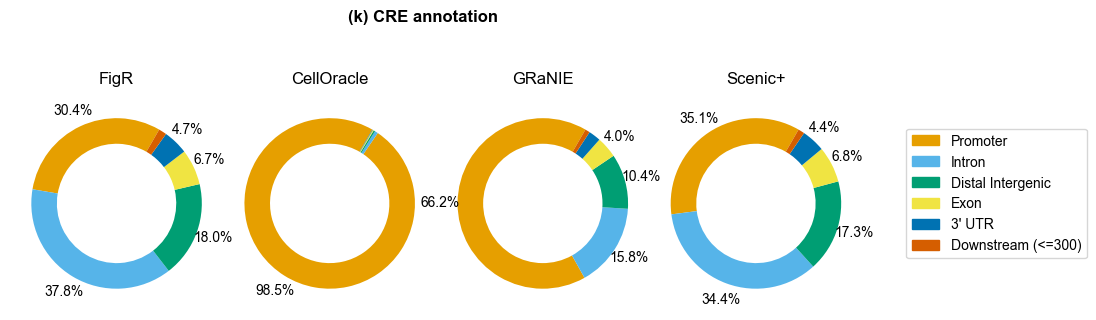

In [182]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{results_folder}/explanatory_analysis/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()